# 2 - Análise Exploratória de Séries Temporais - Faturamento Total

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook é uma continuação da análise exploratória inicial.

Neste notebook, vamos progredir para a análise exploratória de séries temporais.

In [2]:
# importação de bibliotecas
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

# importação de bibliotecas de análise
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import auto_arima

# teste para verificar estacionariedade (Dickey-Fuller: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
from statsmodels.tsa.stattools import adfuller

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae 

# pacote com funções para análise desse projeto
import os
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform
os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados

In [3]:
ts_raw = pd.read_csv(r'../data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)
fat_total = tswide.sum(axis = 'columns').dropna()

In [4]:
fat_total

date
2009-12-01    1.006195e+09
2010-01-01    9.993524e+08
2010-02-01    1.000041e+09
2010-03-01    9.905806e+08
2010-04-01    9.947466e+08
                  ...     
2021-06-01    2.086224e+09
2021-07-01    2.073233e+09
2021-08-01    2.101590e+09
2021-09-01    2.179518e+09
2021-10-01    2.193340e+09
Freq: MS, Length: 143, dtype: float64

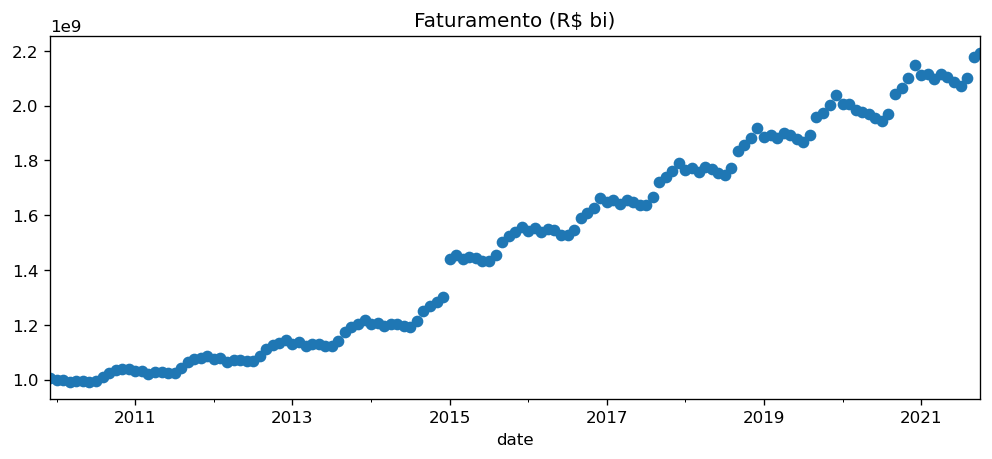

In [5]:
fat_total.plot(linestyle = '', marker = 'o')
plt.title('Faturamento (R$ bi)')
plt.show()

## Análise Exploratória

Vamos primeiramente analisar o faturamento total contido na série histórica:

In [6]:
fat_total = tsd['total']
fat_total.describe()

count    1.430000e+02
mean     1.496520e+09
std      3.836341e+08
min      9.905806e+08
25%      1.122928e+09
50%      1.527953e+09
75%      1.861295e+09
max      2.193340e+09
Name: faturamento_total, dtype: float64

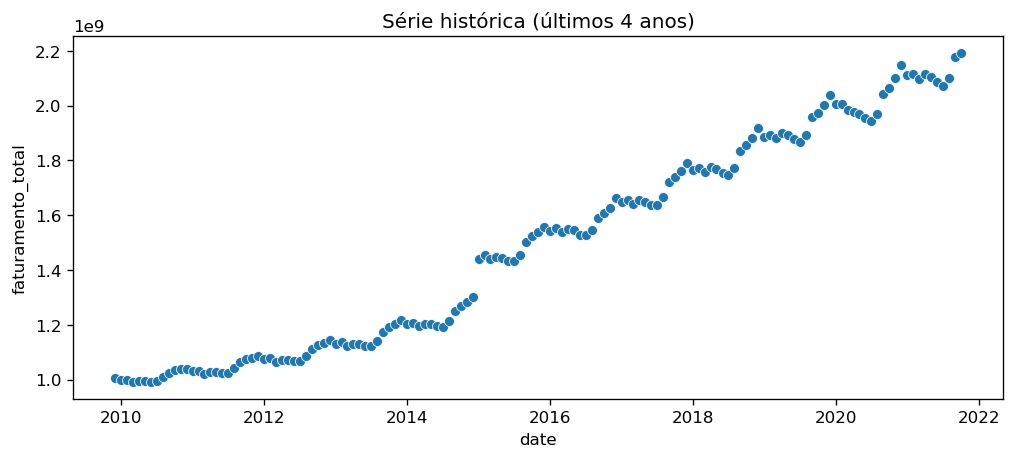

In [7]:
sns.scatterplot(data = fat_total)
plt.title('Série histórica (últimos 4 anos)')
plt.show()

Parece haver um salto entre 2014 e 2015 no faturamento total. 

Esse salto é devido ao lançamento de um outro produto, `transporte`. O faturamento deste novo produto é uma ordem de magnitude menor que o faturamento do produto `alimenticio` (como vimos brevemente no gráfico de dados faltantes e veremos com detalhes mais a frente), mas é o suficiente para que seja notado no faturamento total.

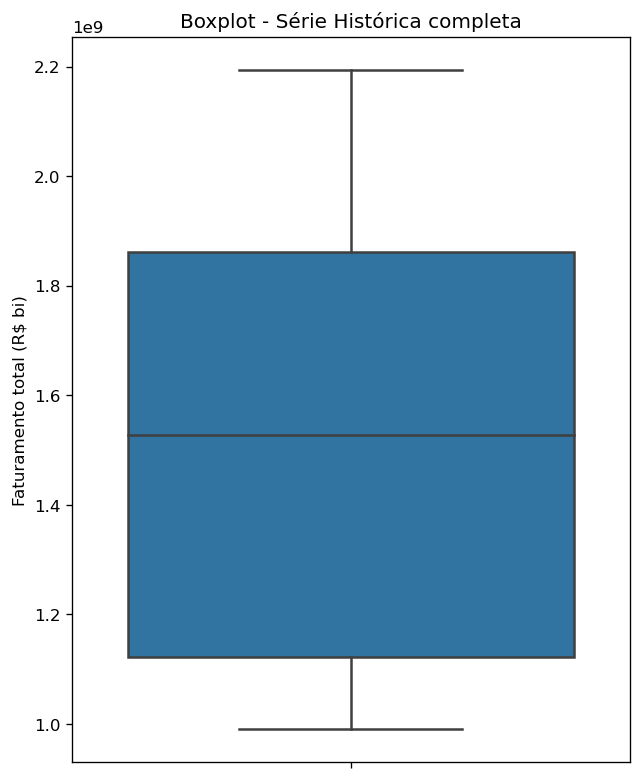

In [8]:
fig = plt.figure(figsize = (6, 8))
sns.boxplot(y = fat_total)
plt.ylabel('Faturamento total (R$ bi)')
plt.title('Boxplot - Série Histórica completa')
plt.show()

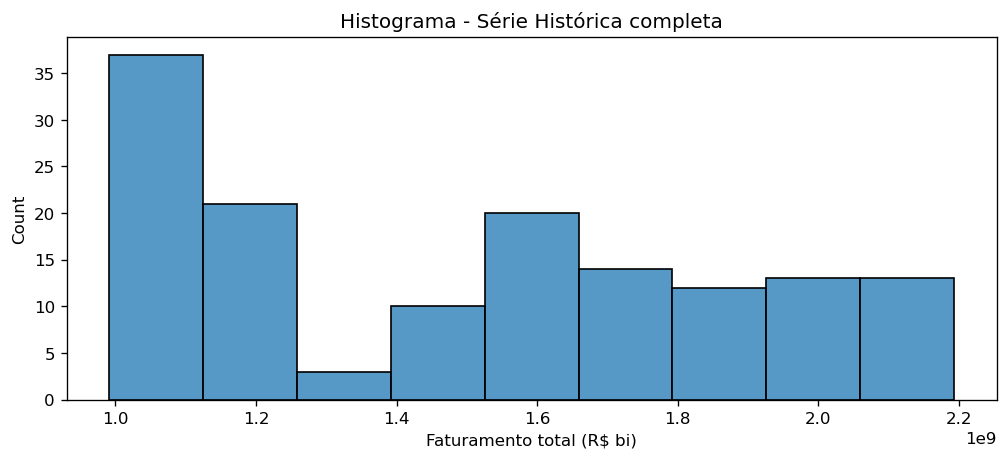

In [9]:
sns.histplot(fat_total)
plt.xlabel('Faturamento total (R$ bi)')
plt.title('Histograma - Série Histórica completa')
plt.show()

No entanto, medidas descritivas de séries temporais devem ser tomadas em relação ao tempo. Vamos separar essas medidas ano a ano:

In [10]:
n_anos = 4
anos_recentes = fat_total[fat_total.index >= dt.datetime.now() - dt.timedelta(days = n_anos * 365) + pd.tseries.offsets.YearBegin()]
anos_recentes.describe()

count    4.500000e+01
mean     1.961071e+09
std      1.257704e+08
min      1.748082e+09
25%      1.881462e+09
50%      1.969575e+09
75%      2.073233e+09
max      2.193340e+09
Name: faturamento_total, dtype: float64

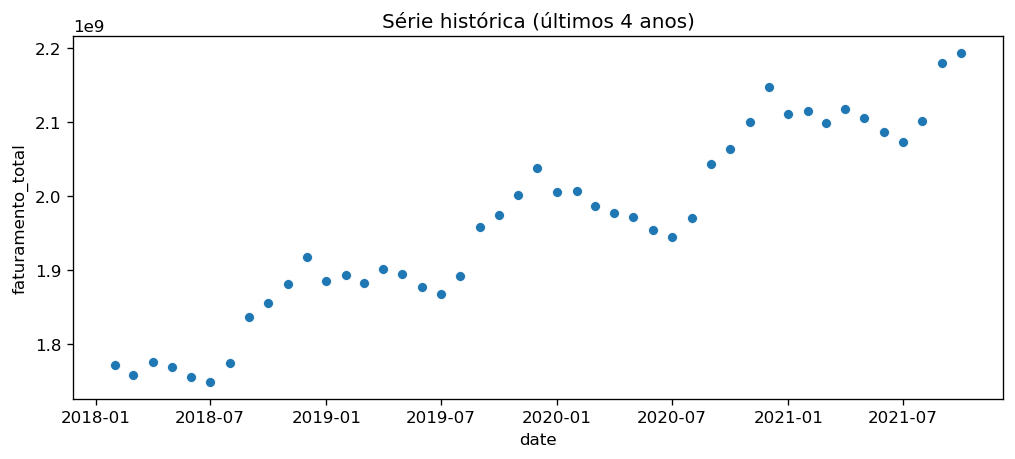

In [11]:
sns.scatterplot(data = anos_recentes)
plt.title(f'Série histórica (últimos {n_anos} anos)')
plt.show()

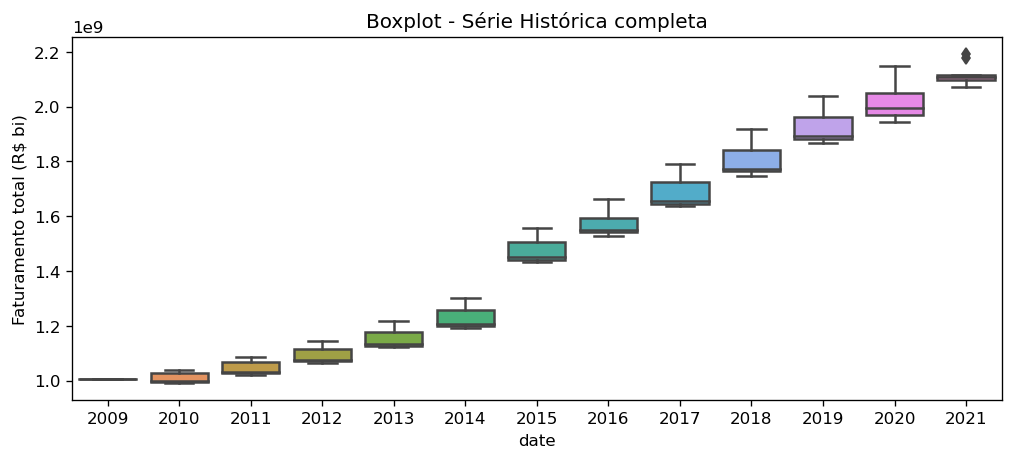

In [12]:
sns.boxplot(y = fat_total, x = fat_total.index.year)
plt.ylabel('Faturamento total (R$ bi)')
plt.title('Boxplot - Série Histórica completa')
plt.show()

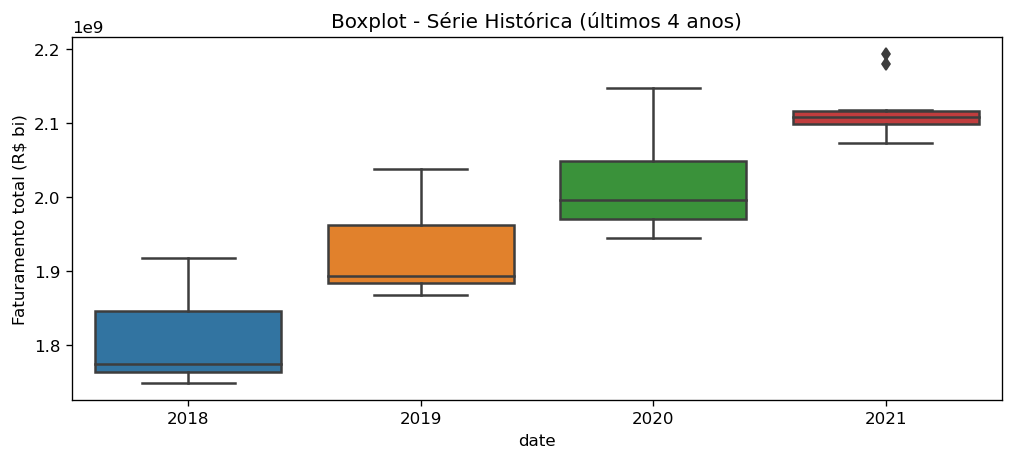

In [13]:

sns.boxplot(y = anos_recentes, x = anos_recentes.index.year)
plt.ylabel('Faturamento total (R$ bi)')
plt.title(f'Boxplot - Série Histórica (últimos {n_anos} anos)')
plt.show()

Parece haver alguns *outliers* em 2021.

No entanto, a série de 2021 está incompleta (vai somente até outubro). Historicamente, há um salto no faturamento em agosto, o que pode estar causando essa deturpação das medidas descritivas.

Excluindo o ano de 2021...

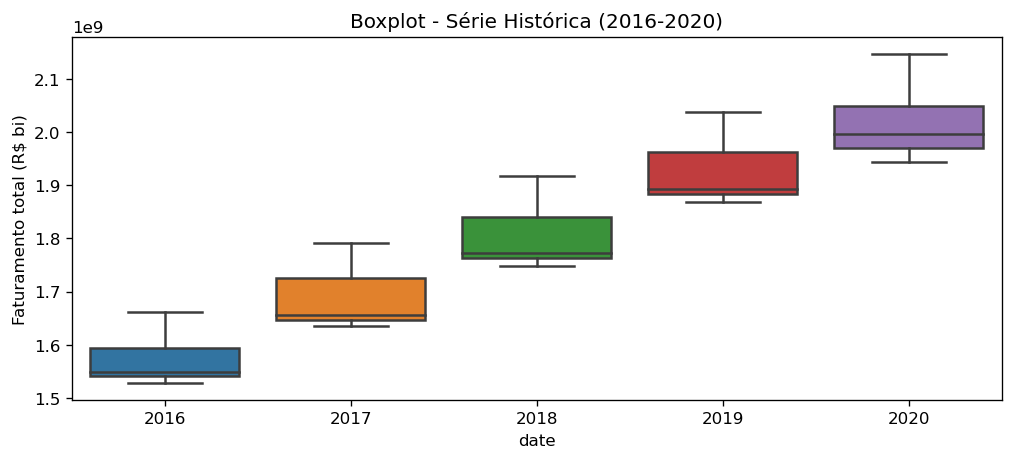

In [14]:
anos_recentes_exc2021 = fat_total[(fat_total.index >= '2016') & (fat_total.index < '2021')]
sns.boxplot(y = anos_recentes_exc2021, x = anos_recentes_exc2021.index.year)
plt.ylabel('Faturamento total (R$ bi)')
plt.title(f'Boxplot - Série Histórica (2016-2020)')
plt.show()

A pandemia se faz notar nos dados apenas com o aumento ligeiro da mediana em relação à distância entre o Q1 e o Q3.

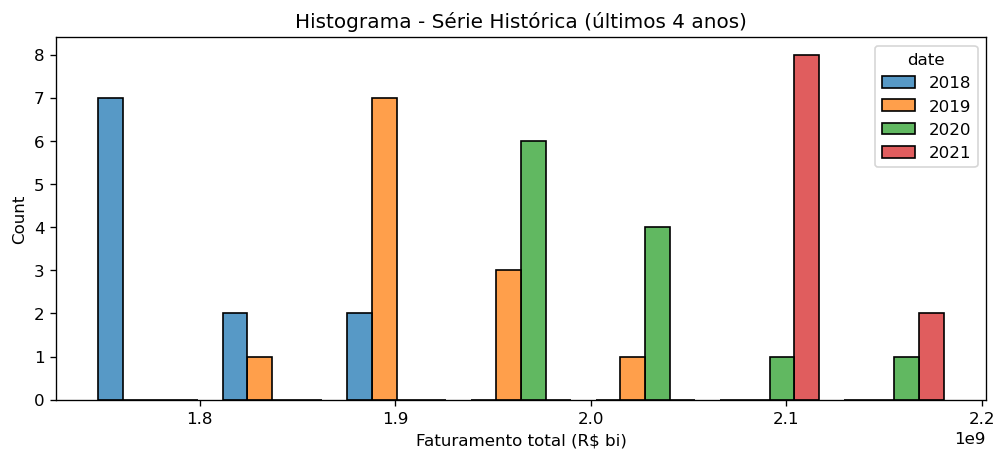

In [15]:
sns.histplot(x = anos_recentes, hue = anos_recentes.index.year, multiple = 'dodge', shrink = .8, common_norm = False, palette = sns.color_palette()[:4])
plt.xlabel('Faturamento total (R$ bi)')
plt.title(f'Histograma - Série Histórica (últimos {n_anos} anos)')
plt.show()

Os histogramas ano a ano estão melhor comportados que o histograma da série histórica completa.

Fazendo uma análise mês a mês para cada ano...

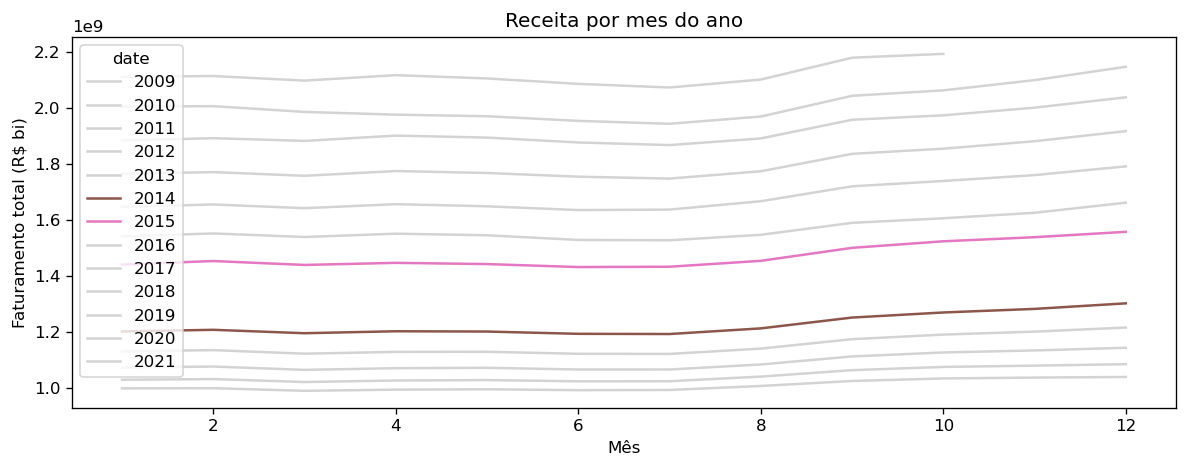

In [16]:
hue = fat_total.index.year

palette = []
for i, year in enumerate(hue.unique()):
    if year not in [2014, 2015]:
        palette += ['lightgray']
    else:
        palette += [sns.color_palette()[i]]

ax = sns.lineplot(
    y = fat_total, x = fat_total.index.month, 
    hue = fat_total.index.year,
    palette = palette
)
ax.set_xlabel('Mês')
ax.set_ylabel('Faturamento total (R$ bi)')
ax.set_title(f"Receita por mes do ano")
plt.tight_layout()
plt.show()

... nota-se claramente o salto dado de 2014 para 2015 com a entrada do novo produto.

## Estacionariedade

Para que a série de faturamentos mensais totais possa ser decomposta, é necessário que ela seja estacionária. 

Não parece ser, mas vamos testar através do teste estatístico de Dickey-Fuller.

A hipótese nula do teste de Dickey-Fuller é que a série é um passeio aleatório (random walk):

In [17]:
testedf = adfuller(fat_total)
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula.')

Valor-p: 98.342% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula.


Isso é evidenciado pela decomposição da série temporal.

## Decomposição em séries de Fourier

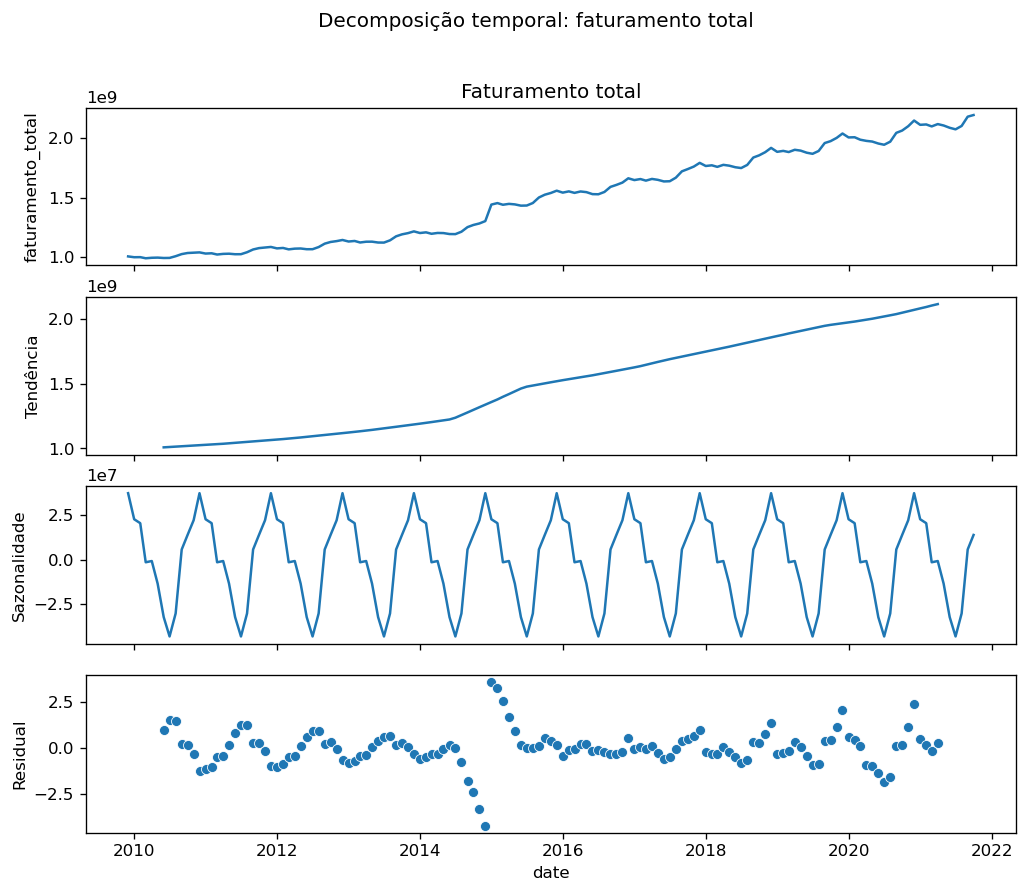

In [18]:
decomp_total = seasonal_decompose(fat_total)

# plot      
fig, axs = plt.subplots(nrows = 4, figsize = (10, 8), sharex = True)

sns.lineplot(data = fat_total, ax = axs[0])
axs[0].set_title('Faturamento total')

sns.lineplot(data = decomp_total.trend, ax = axs[1])
axs[1].set_ylabel('Tendência')

sns.lineplot(data = decomp_total.seasonal, ax = axs[2])
axs[2].set_ylabel('Sazonalidade')

resid = (decomp_total.resid - decomp_total.resid.mean())/decomp_total.resid.std()
sns.scatterplot(data = resid, ax = axs[3])
axs[3].set_ylabel('Residual')

fig.suptitle(f"Decomposição temporal: faturamento total")
plt.show()

Como mostrado anteriormente, esta série temporal não é estacionária, o que podemos ver através dos resíduos padronizados do último quadro (onde há um padrão claro oscilatório).

## Modelo autorregressivo - Faturamento total

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

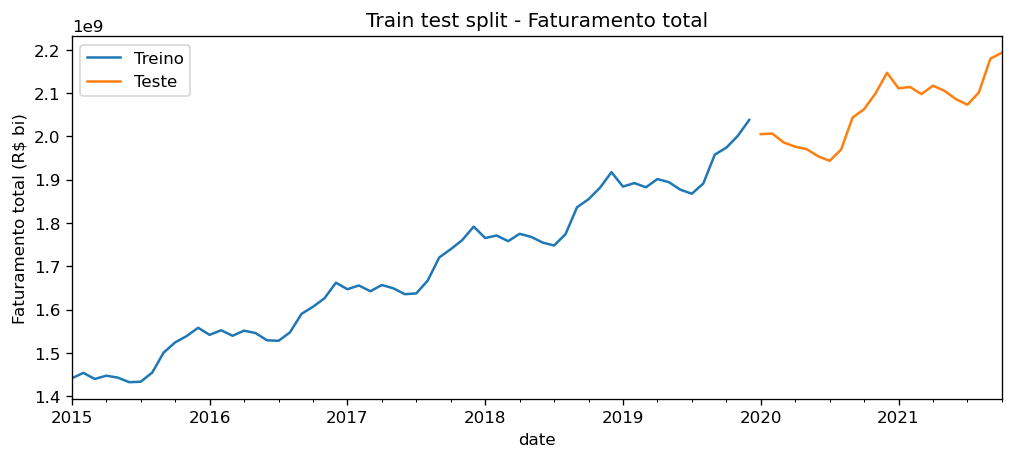

In [25]:
# excluindo o período pré-2015

test_begin = '2020-01-01'
total_train = fat_total['2015-01-01':test_begin].iloc[:-1]
total_test = fat_total[test_begin:]

total_train.plot(label = 'Treino')
total_test.plot(label = 'Teste')
plt.title('Train test split - Faturamento total')
plt.ylabel('Faturamento total (R$ bi)')
plt.legend()
plt.show()

O modelo SARIMA contém alguns parâmetros, `S(P, D, Q, S)`, `AR(p)`, `I(d)` e `MA(q)`.

Para determinarmos o parâmetro `d`, uma boa indicação é o gráfico de autocorrelação:

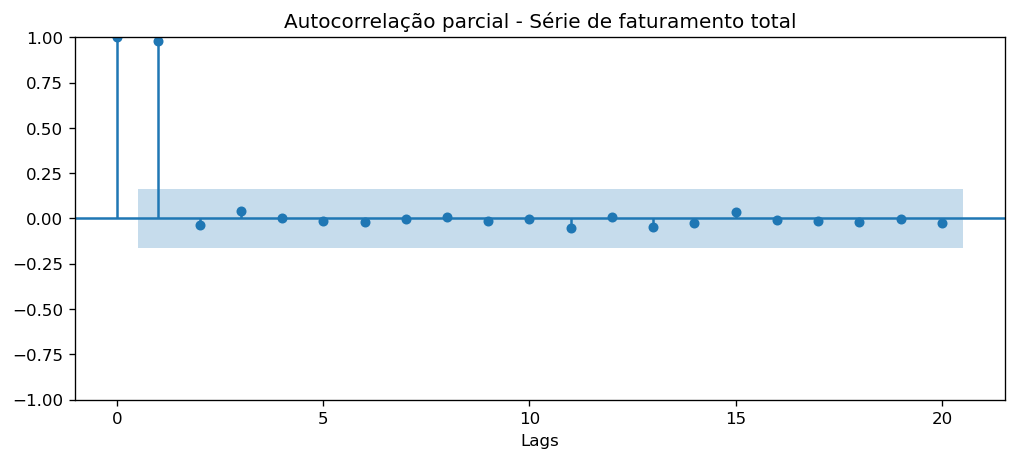

In [20]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_total, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title('Autocorrelação parcial - Série de faturamento total')
plt.show()

Neste caso, uma boa estimativa para o parâmetro `d` é 1 subtraído do número de *lags* em que a correlação é estatisticamente significativa. 

Neste caso, $d = 1$.

In [21]:
arimas = {}
arimas['total'] = auto_arima(
    y = total_train,
    start_p = 1, max_p = 3,
    d = 1,
    start_q = 1, max_q = 3,
    start_P = 1, max_P = 3,
    D = None, max_D = 4,
    start_Q = 1, max_Q = 3,
    #max_order = 6,
    m = 12,
    seasonal = True
    #alpha = 0.05
)


In [22]:
arimas['total'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -793.399
Date:                            Tue, 16 Nov 2021   AIC                           1588.799
Time:                                    20:17:06   BIC                           1590.649
Sample:                                         0   HQIC                          1589.495
                                             - 60                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.041e+13   2.46e+12      8.313      0.000    1.56e+13    2.52e+13
===================================================================================
Ljung-Box (L1) (Q):                   3.83   Jarque-Bera (JB):                 6.52
Prob(Q):                              0.05   Prob(JB):                         0.04
Heteroskedasticity (H):               0.57   Skew:                             0.59
Prob(H) (two-sided):                  0.27   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Métricas para o modelo autorregressivo SARIMAX

Primeiramente, podemos avaliar o ajuste visualmente:

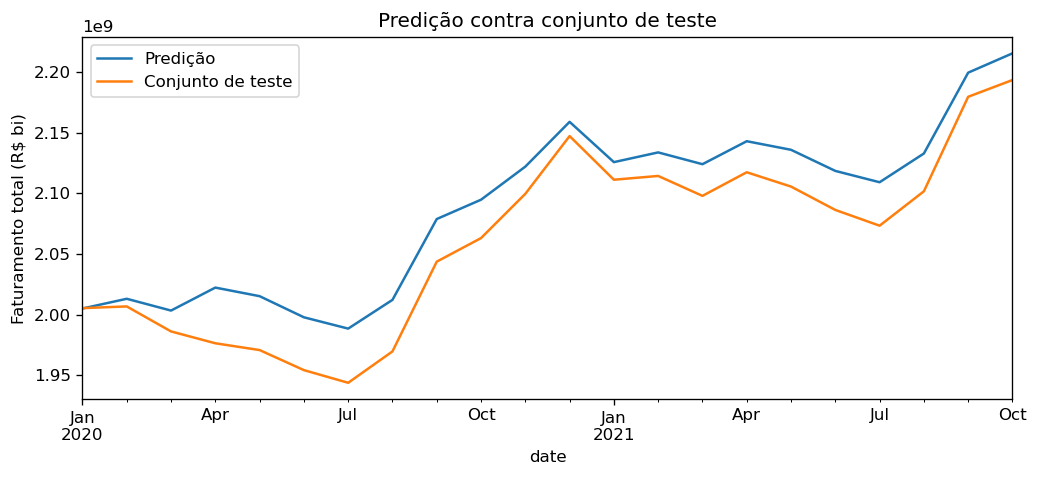

In [23]:
n_test_periods = total_test.shape[0]
arr_preds = arimas['total'].predict(n_test_periods)

idx = pd.date_range(freq = 'MS', start = test_begin, periods = n_test_periods)
preds = pd.Series(arr_preds, index = idx)
preds.name = 'yearly_preds'

preds.plot(label = 'Predição')
total_test.plot(label = 'Conjunto de teste')

plt.legend()
plt.ylabel('Faturamento total (R$ bi)')
plt.title('Predição contra conjunto de teste')
plt.show()

Vamos aplicar algumas métricas quantitativas ao modelo:

In [24]:
kwargs_total = dict(
    y_true = total_test,
    y_pred = preds
)

metricas = dict(
    total = dict(
        mape = smape(**kwargs_total),
        rmse = np.sqrt(smse(**kwargs_total)),
        mae = smae(**kwargs_total)
    )
)

mape = metricas['total']['mape']
rmse = metricas['total']['rmse']
mae = metricas['total']['mae']

print(f'MAPE: {mape:.3%}')
print(f'RMSE: {rmse:.3e}')
print(f' MAE: {mae:.3e}')

MAPE: 1.341%
RMSE: 3.015e+07
 MAE: 2.740e+07
